In [1]:
# # 查看当前挂载的数据集目录
# !ls /home/aistudio/data/

In [2]:
# # 查看个人持久化工作区文件
# !ls /home/aistudio/work/

<h2>1-解压训练数据与测试数据</h2>

In [3]:
# #解压训练集数据
# #/home/aistudio/data/data1594/train.zip
# !unzip /home/aistudio/data/data1594/train.zip

In [4]:
# !unzip /home/aistudio/data/data1594/test.zip

<h2>2-导入库</h2>

In [1]:
import sys
import numpy as np

import matplotlib.pyplot as plt

import paddle
import paddle.fluid as fluid

%matplotlib inline

In [2]:
from PIL import Image

In [3]:
import os

In [4]:
import random

<h2>3-数据预处理</h2>

<h3>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1图片到数字</h3>

In [5]:
!ls /home/aistudio/train/

0  1  2  3


In [6]:
folder=['train','test']
untrain1=[]
untest1=[]
undata=[untrain1,untest1]
# untest=[]
folder=['train','test']
for i in range(0,len(folder)):
    
    path=r"/home/aistudio/{}".format(folder[i])
    name = []
    for tmp in os.listdir(path):
        name.append(tmp)

    for n in name:
        mpath=path+"/"+n+"/"

        allpicture=os.listdir(mpath)
        os.chdir(mpath)
        for pic in allpicture:
            if pic.endswith("png"):
                ttmp=[]
                img=Image.open(pic)
    #             img=img.resize((64,64),im.ANTIALIAS)
    #             img.save(pic)
                imgnum=np.array(img).astype(np.float32)
                ttmp.append(imgnum)
                ttmp.append(int(n))
                undata[i].append(ttmp)

<h3>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2打乱顺序</h3>

In [7]:
random.shuffle(untrain1)
random.shuffle(untest1)

In [8]:
##检验结果
# for i in xrange(len(untrain)):
#     print(untrain[i][1])
# for i in xrange(len(untest1)):
#     print(untest1[i][1])

<h3>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3构造训练的原始数据</h3>

In [9]:
#为了转化为相应的数据格式
#使用一种中间数据格式
midtrain=[]
midtrainlabel=[]
for m in untrain1:
    midtrain.append(m[0])
    midtrainlabel.append(m[1])

midtest=[]
midtestlabel=[]
for m in untest1:
    midtest.append(m[0])
    midtestlabel.append(m[1])

In [10]:
train_set_x_orig=np.array(midtrain)
train_set_y=np.array(midtrainlabel)
test_set_x_orig=np.array(midtest)
test_set_y=np.array(midtestlabel)

print("train_data:",len(train_set_x_orig))
print("train_label:",len(train_set_y))
print("test_data:",len(test_set_x_orig))
print("test_label:",len(test_set_y))

('train_data:', 6637)
('train_label:', 6637)
('test_data:', 67)
('test_label:', 67)


In [11]:
##数据检测
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]

print ("训练样本数: m_train = " + str(m_train))
print ("测试样本数: m_test = " + str(m_test))
print ("图片高度/宽度: num_px = " + str(num_px))
print ("图片大小: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

训练样本数: m_train = 6637
测试样本数: m_test = 67
图片高度/宽度: num_px = 64
图片大小: (64, 64, 3)
train_set_x shape: (6637, 64, 64, 3)
train_set_y shape: (6637,)
test_set_x shape: (67, 64, 64, 3)
test_set_y shape: (67,)


In [12]:
##更改为paddle识别的数据
train_set_x = np.array(train_set_x_orig).reshape(m_train, 3, 64, 64).astype(np.float32)
train_set_y = np.array(train_set_y).reshape(m_train, 1).astype(np.float32)
test_set_x = np.array(test_set_x_orig).reshape(m_test, 3, 64, 64).astype(np.float32)
test_set_y = np.array(test_set_y).reshape(m_test, 1).astype(np.float32)

In [13]:
print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)

(6637, 3, 64, 64)
(6637, 1)
(67, 3, 64, 64)
(67, 1)


In [14]:
##标准化

train_set_x=train_set_x/ 255.0 * 2.0 - 1.0

test_set_x=test_set_x/ 255.0 * 2.0 - 1.0

<h2>构造Reader</h2>

In [15]:
# 读取训练数据或测试数据
def read_data(train_set_x,train_set_y,buffer_size):
   
    def reader():
       
        for i in xrange(buffer_size):            
            yield train_set_x[i,:], int(train_set_y[i])            
    return reader


<h2>实现卷积分类</h2>

In [16]:

def convolutional_neural_network():

    img = fluid.layers.data(
        name='img', shape =[3,64,64],dtype = 'float32')

    hidden=fluid.nets.simple_img_conv_pool(
    input=img,
        num_filters=20,
        filter_size=3,
        pool_size=2,
        pool_stride=1,
        pool_padding=0
    )
    h2=fluid.nets.simple_img_conv_pool(
    input=hidden,
        num_filters=50,
        filter_size=3,
        pool_size=2,
        pool_stride=1,
        pool_padding=0
    )
    predict = fluid.layers.fc(h2,size=4,act='softmax')

    return predict


<h2>开始训练</h2>

In [17]:
# 设置训练场所
use_cuda = False
# use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

In [18]:
def train_func():
    
    label = fluid.layers.data(name='label', shape = [1],dtype = 'int64')

    predict = convolutional_neural_network()

    # 损失函数，cross_entropy 函数内部使用交叉熵损失函数
    cost = fluid.layers.cross_entropy(input=predict, label=label)
    avg_cost = fluid.layers.mean(cost)
    return avg_cost



In [19]:
def optimizer_func():
  
    optimizer=fluid.optimizer.Momentum(learning_rate=0.001,momentum=0.9)
    
    return optimizer

In [20]:
feed_order = ['img', 'label'] 

In [21]:
params_dirname = "./DNN_model"

In [22]:

# Plot data
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)

step = 0
# 事件处理
def event_handler_plot(event):
    global step
    if isinstance(event, fluid.EndStepEvent):
        if event.step % 2 == 0: # 若干个batch,记录cost
            if event.metrics[0] < 10:
                plot_cost.append(train_title, step, event.metrics[0])
                plot_cost.plot()
        if event.step % 20 == 0: # 若干个batch,记录cost
            test_metrics = trainer.test(
            reader=test_reader, feed_order=feed_order)
            if test_metrics[0] < 10:
                plot_cost.append(test_title, step, test_metrics[0])
                plot_cost.plot()

#             if test_metrics[0] < 1.0:
#                 # 如果准确率达到阈值，则停止训练
#                 print('loss is less than 10.0, stop')
#                 trainer.stop()

        # 将参数存储，用于预测使用
        if params_dirname is not None:
            trainer.save_params(params_dirname)
    step += 1

In [23]:
# 设置 BATCH_SIZE 的大小
### START CODE HERE ### (≈ 1 lines of code) 
BATCH_SIZE=16
### END CODE HERE ###

# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        read_data(train_set_x,train_set_y,buffer_size=209), 
        buf_size=50),
    batch_size=BATCH_SIZE)

# 设置测试reader
test_reader = paddle.batch(
    paddle.reader.shuffle(
        read_data(test_set_x,test_set_y,buffer_size=50), 
        buf_size=20),
    batch_size=BATCH_SIZE)


In [24]:
#创建训练器
trainer = fluid.Trainer(
    train_func= train_func,
    place= place,
    optimizer_func= optimizer_func)


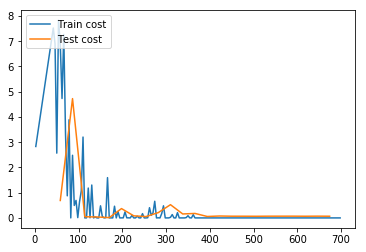

<Figure size 432x288 with 0 Axes>

In [25]:

### START CODE HERE ### (≈ 4 lines of code)
trainer.train(
    reader=train_reader,
    num_epochs=25 ,
    event_handler=event_handler_plot ,
    feed_order=feed_order )



### END CODE HERE ###

<h2>预测</h2>

In [26]:
inferencer = fluid.Inferencer(
    infer_func=convolutional_neural_network, param_path=params_dirname, place=place)

In [27]:
# 取出一个 mini-batch
for mini_batch in test_reader(): 
    # 转化为 numpy 的 ndarray 结构，并且设置数据类型
    test_x = np.array([data[0] for data in mini_batch]).astype("float32")
    test_y = np.array([data[1] for data in mini_batch]).astype("int64")
    # 真实进行预测
    mini_batch_result = inferencer.infer({'img': test_x})
    
#     result=(mini_batch_result[0][:,-1]>0.5)+0   #True or False 转0/1，直接后面+0即可
#     上述函数单分类用
    
    
    # 打印预测结果
    mini_batch_result = np.argsort(mini_batch_result) #找出可能性最大的列标，升序排列,
    
    ###目的是啥啊，为啥升序排列啊
    ###经过分析，这是多分类问题会用到的函数，找出概率值最大的下标
    
    
    mini_batch_result = mini_batch_result[0][:, -1]  #把这些列标拿出来

#     print('预测结果：%s'%result)
    print('预测结果：%s'%mini_batch_result)
    
    # 打印真实结果    
    label = np.array(test_y) # 转化为 label
    print('真实结果：%s'%label)
    break    

预测结果：[2 1 0 1 3 0 0 0 2 2 0 2 0 2 0 2]
真实结果：[2 1 0 1 3 0 0 0 2 2 0 2 0 2 0 2]


In [28]:
# 查看百分比
def right_ratio(right_counter, total):
    ratio = float(right_counter)/total
    return ratio

# 评估函数 data_set 是一个reader
def evl(data_set):
    total = 0    #操作的元素的总数
    right_counter = 0  #正确的元素

    pass_num = 0
#     print(liruoyi)
    for mini_batch in data_set():
        pass_num += 1
        #预测
        test_x = np.array([data[0] for data in mini_batch]).astype("float32")
        test_y = np.array([data[1] for data in mini_batch]).astype("int64")
        mini_batch_result = inferencer.infer({'img': test_x})
        
#         mini_batch_result=(mini_batch_result[0][:,-1]>0.5)+0   #True or False 转0/1，直接后面+0即可
###       二分类预测
        
        #预测的结果
        mini_batch_result = np.argsort(mini_batch_result) #找出可能性最大的列标，升序排列
        mini_batch_result = mini_batch_result[0][:, -1]  #把这些列标拿出来

#         print('预测结果：%s'%result)

        label = np.array(test_y) # 转化为 label
#         print('真实结果：%s'%label)

        #计数
        label_len = len(label)
        total += label_len
        for i in xrange(label_len):
            if mini_batch_result[i] == label[i]:
                right_counter += 1

    ratio = right_ratio(right_counter, total)
    return ratio

ratio = evl(train_reader)
print('训练数据的正确率 %0.2f%%'%(ratio*100))

ratio = evl(test_reader)
print('预测数据的正确率 %0.2f%%'%(ratio*100))

训练数据的正确率 100.00%
预测数据的正确率 97.92%
